In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Solve the imshow dead kernel problem
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
'''
Start loading the data
'''
print('================== START LOADING DATA ==================')

================== START LOADING DATA ==================


In [ ]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

In [ ]:
# Split the training set into a 80% training set and 20% validation set
import random

def split_huge_file(file,out1,out2,percentage=0.75,seed=2022):
    """Splits a file in 2 given the approximate `percentage` to go in the large file."""
    random.seed(seed)
    with open(file, 'r',encoding="utf-8") as fin, \
         open(out1, 'w') as foutBig, \
         open(out2, 'w') as foutSmall:

        for line in fin:
            r = random.random() 
            if r < percentage:
                foutBig.write(line)
            else:
                foutSmall.write(line)

In [ ]:
path = '/content/drive/My Drive/'
split_huge_file(os.path.join(path, f'train_triplets.txt'), 'train_triplets_splits.txt', 'val_triplets_splits.txt', percentage=0.8, seed=2022)

In [ ]:
# Image loader helper function
def default_image_loader(path):
    return Image.open(path).convert('RGB')

In [ ]:
# Dataset
im = Image.open(r"/content/drive/My Drive/food/00003.jpg")

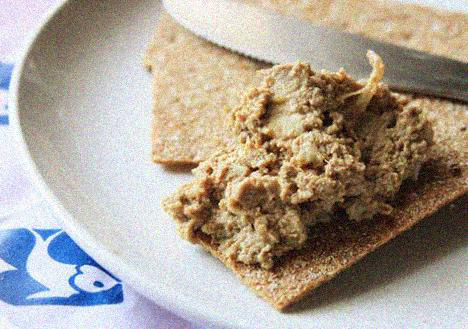

In [ ]:
display(im)

In [ ]:
data = np.asarray(im)
data.shape

(329, 468, 3)

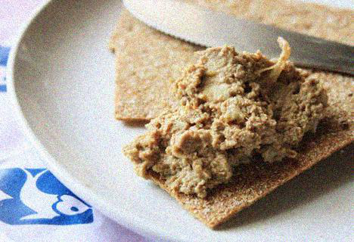

In [ ]:
im.resize((354,242))

In [ ]:
class TripletImageLoader(torch.utils.data.Dataset):
    def __init__(self, base_path, triplets_file_name, transform=None, loader=default_image_loader):
        """ base_path: The path contains the text file of the training triplets
            triplets_file_name: The text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file.  
            Each line contains three integers (a triplet).
            For example, the triplet "00723 00478 02630" denotes that the dish in image "00723.jpg" is more similar in taste 
            to the dish in image "00478.jpg" than to the dish in image "02630.jpg" according to a human annotator.
         """
        self.base_path = base_path  
        triplets = []
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, positive, negative
        self.triplets = triplets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        img1 = self.loader(os.path.join(self.base_path, f'{path1}.jpg'))
        img2 = self.loader(os.path.join(self.base_path, f'{path2}.jpg'))
        img3 = self.loader(os.path.join(self.base_path, f'{path3}.jpg'))
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3

    def __len__(self):
        return len(self.triplets)

In [ ]:
# Initialization: importing the packages that we will use
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Google colab offers time limited use of GPU for free

################# Configuration  ######################
IMAGE_SIZE = (242, 354) # bigger image size improves performance but makes training slower.

# Training parameters 
BATCH_SIZE = 64

In [ ]:
torch.cuda.is_available()

False

In [ ]:
device

'cpu'

In [ ]:
# Dataset and Trasformations
import torchvision
import torchvision.transforms as transforms

############# Datasets and Dataloaders ################
transform_train = transforms.Compose([
    transforms.ToTensor(), # The output of torchvision datasets are PILImage images of range [0, 1].
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5), # we want our network to be robust over geometrical transformations that leave the image semantically invariant
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #  We transform them to Tensors of normalized range [-1, 1].
    # (mean, mean, mean) , (std, std, std): output[channel] = (input[channel] - mean[channel]) / std[channel]
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

path = '/content/drive/MyDrive/food'
train_dataset = TripletImageLoader(path.rstrip('\n'), 'train_triplets_splits.txt', transform=transform_train)
val_dataset = TripletImageLoader(path.rstrip('\n'), 'val_triplets_splits.txt', transform=transform_val)
test_dataset = TripletImageLoader(path.rstrip('\n'), 'test_triplets.txt', transform=transform_test)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(47574, 11941, 59544)

In [ ]:
test_dataset[0]

(tensor([[[ 0.6848,  0.6188,  0.6295,  ...,  0.6845,  0.6174,  0.5918],
          [ 0.7634,  0.6081,  0.6502,  ...,  0.7868,  0.7373,  0.6763],
          [ 0.7259,  0.7257,  0.6671,  ...,  0.7282,  0.7121,  0.6763],
          ...,
          [ 0.1368,  0.1779,  0.1858,  ...,  0.5491,  0.5174,  0.5192],
          [ 0.1719,  0.1433,  0.1679,  ...,  0.5418,  0.5576,  0.5111],
          [ 0.2298,  0.0134,  0.0636,  ...,  0.6480,  0.7295,  0.7176]],
 
         [[ 0.3083,  0.2423,  0.2557,  ...,  0.2424,  0.3027,  0.3446],
          [ 0.3778,  0.2235,  0.2622,  ...,  0.3537,  0.3888,  0.3711],
          [ 0.3208,  0.3215,  0.2648,  ...,  0.3097,  0.3167,  0.2928],
          ...,
          [-0.2550, -0.2139, -0.2107,  ...,  0.0953,  0.1322,  0.1737],
          [-0.2046, -0.2332, -0.2138,  ...,  0.0879,  0.1528,  0.1360],
          [-0.1141, -0.3449, -0.3147,  ...,  0.1256,  0.0728, -0.0351]],
 
         [[ 0.1512,  0.0762,  0.0626,  ..., -0.0076, -0.0635, -0.0872],
          [ 0.2222,  0.0503,

In [ ]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
len(train_loader), len(val_loader)

(744, 187)

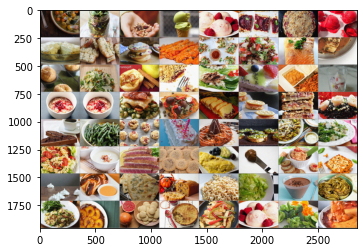

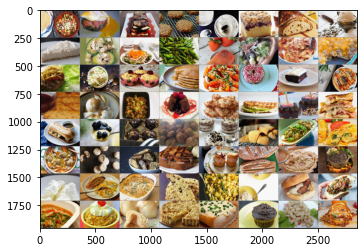

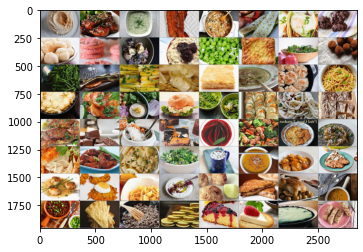

In [ ]:
# Visualization of Dataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images_anchor, images_positive, images_negative = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_anchor))
imshow(torchvision.utils.make_grid(images_positive))
imshow(torchvision.utils.make_grid(images_negative))

In [ ]:
'''
Data loaded
'''
print('================== DATA LOADED ==================')

================== DATA LOADED ==================


In [ ]:
'''
Start constructing the network
'''
print('================== START CONSTRUCTING NETWORK ==================')

================== START CONSTRUCTING NETWORK ==================


In [ ]:
# import torch.optim
# import torch.utils.data
# import torch
# import torchvision
# import torch.nn as nn
# import torchvision.models as models
# import torch.utils.data
# import torch.backends.cudnn as cudnn

# #########################NET##############################

# #The backbone for the CNNS with shared weights
# def backbone(**kwargs):
#     """
#     Construct a ResNet-101 model.
#     Returns:
#         Embeddingnet(model): The CNN with the specified model as its backbone is instantiated
#     """
#     #model = torch.hub.load('pytorch/vision:v1.7.1', 'resnet101', pretrained=True)
#     model = models.resnet18(pretrained=True)
#     #model = models.resnet34(pretrained=True)
#     #model = models.vgg11_bn()
#     #model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=True)
#     #model = models.alexnet(pretrained=True)            #used in the paper
#     #print('Layers',model.children)
#     #model = models.resnet50(pretrained=True)
#     #model = models.inception_v3(pretrained=True)
#     #model = torchvision.models.resnet.ResNet(
#         #torchvision.models.resnet.BasicBlock, [2, 1, 1, 1])

#     return EmbeddingNet(model)

# #The overall network consisting of three embedding nets with shared weights
# class TripletNet(nn.Module):
#     """Triplet Network."""

#     def __init__(self, embeddingnet):
#         """Triplet Network Builder."""
#         super(TripletNet, self).__init__()
#         self.embeddingnet = embeddingnet
#         #print(self.embeddingnet.children())

#     def forward(self, a, p, n):
#         """Forward pass."""
#         # anchor
#         embedded_a = self.embeddingnet(a)

#         # positive examples
#         embedded_p = self.embeddingnet(p)

#         # negative examples
#         embedded_n = self.embeddingnet(n)

#         return embedded_a, embedded_p, embedded_n

# #The CNN used by Triplet Net with 'model' as its backbone and a final fully connected Layer
# class EmbeddingNet(nn.Module):
#     """EmbeddingNet using the specified model in backbone()."""

#     def __init__(self, resnet):
#         """Initialize EmbeddingNet model."""
#         super(EmbeddingNet, self).__init__()
#         # Everything excluding the last linear layer
#         self.features = nn.Sequential(*list(resnet.children())[:-1])
#         num_ftrs =  resnet.fc.in_features
#         self.fc1 = nn.Linear(num_ftrs, 1024)

#     def forward(self, x):
#         """Forward pass of EmbeddingNet."""
#         out = self.features(x)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         return out

In [ ]:
# Construct a triplet net
import torch.optim
import torch.utils.data
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.utils.data
import torch.backends.cudnn as cudnn

#########################NET##############################

#The backbone for the CNNS with shared weights
def FeatureExtractNET(**kwargs):
    """
    Construct a ResNet-101 model.
    Returns: The CNN for feature extraction with a fully connected layer
    """
    model = models.resnet18(pretrained=True)

    return EmbeddingNet(model)

#The CNN used by Triplet Net with 'model' as its backbone and a final fully connected Layer
class EmbeddingNet(nn.Module):
    """EmbeddingNet using the specified model in backbone()."""

    def __init__(self, resnet):
        """Initialize EmbeddingNet model."""
        super(EmbeddingNet, self).__init__()
        # Everything excluding the last linear layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs =  resnet.fc.in_features
        self.fc1 = nn.Linear(num_ftrs, 1024)

    def forward(self, x):
        """Forward pass of EmbeddingNet."""
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
#The overall network consisting of three embedding nets with shared weights
class TripletNet(nn.Module):
    """Triplet Network."""

    def __init__(self, embeddingnet):
        """Triplet Network Builder."""
        super(TripletNet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, a, p, n):
        """Forward pass."""
        # anchor
        embedded_a = self.embeddingnet(a)

        # positive examples
        embedded_p = self.embeddingnet(p)

        # negative examples
        embedded_n = self.embeddingnet(n)

        return embedded_a, embedded_p, embedded_n

In [ ]:
net = TripletNet(FeatureExtractNET())

#Move the net to GPU for training
print("==> Initialize CUDA support for TripletNet model ...")
net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True
net

==> Initialize CUDA support for TripletNet model ...


DataParallel(
  (module): TripletNet(
    (embeddingnet): EmbeddingNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# batch = next(iter(train_loader))
# batch[0], batch[1], batch[2] = batch[0].cuda(), batch[1].cuda(), batch[2].cuda()
# net(batch[0],batch[1],batch[2])[0].size()

In [ ]:
# import hiddenlayer as hl

# transforms = [hl.transforms.Prune('Constant')] # Removes Constant nodes from graph.

# graph = hl.build_graph(net, (batch[0], batch[1], batch[2]), transforms=transforms)
# graph.theme = hl.graph.THEMES['blue'].copy()
# graph.save('rnn_hiddenlayer_1', format='png')

In [ ]:
import torch.optim as optim
criterion = nn.TripletMarginLoss(margin=5.0, p=2)

optimizer = optim.SGD(net.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=2e-3,#The value used in the paper is 1e-3
                            nesterov=True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# from torch.autograd import Variable
# for epoch in range(1):

#         running_loss = 0.0
#         loss_train = 0.0
#         for batch_idx, (data1, data2, data3) in enumerate(train_loader):

# #             if is_gpu:
# #                 data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

#             # wrap in torch.autograd.Variable
#             data1, data2, data3 = Variable(
#                 data1), Variable(data2), Variable(data3)
#             print('anchor', data1.size())
#             print('positive', data2.size())
#             print('negative', data3.size())

#             # compute output and loss
#             embedded_a, embedded_p, embedded_n = net(data1, data2, data3)
#             loss = criterion(embedded_a, embedded_p, embedded_n)
#             print(loss)

#             # compute gradient and do optimizer step
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # print the loss
#             running_loss += loss.data

# #             loss_train_cls = torch.sum(
# #                 1 * (criterion_val(embedded_a, embedded_p,
# #                                    embedded_n) > 0)) / train_batch_size  # CHANGED, MAY NEED TO REVERT BACK

# #             loss_train += loss_train_cls.data

#             if batch_idx % 30 == 0:
#                 print("mini Batch Loss: {}".format(loss.data))

In [ ]:
'''
Network constructed
'''
print('================== NETWORK CONSTRUCTED ==================')

================== NETWORK CONSTRUCTED ==================


In [ ]:
# import torch
# import torch.nn as nn
# pdist = nn.PairwiseDistance(p=2)
# input1 = torch.randn(64, 1024)
# input2 = torch.randn(64, 1024)
# input3 = torch.randn(64, 1024)
# print(input1.size())
# print(input2.size())
# print(input3.size())
# dist1 = pdist(input1, input2)
# dist2 = pdist(input1, input3)
# print(dist1.size())
# print(dist2.size())
# pred = dist1 - dist2
# print(pred.size())
# sum = 0
# for i in range(pred.size()[0]):
#   if pred[i] < 0:
#     sum+=1
# print(sum/pred.size()[0])
# print((pred < 0).sum()*1.0/pred.size()[0])

In [ ]:
# import random
# for i in range(10):
#   a = random.randint(0,10)
#   print(a)

In [ ]:
import torch.nn.functional as F

def accuracy(dista, distb):
    margin = 0
    pred = (dista - distb).cpu().data
    return (pred < 0).sum()*1.0/dista.size()[0]

def val_accuracy(valloader, valloader_iter):
  # sum_accuracy = 0
  # num_batch_evaluated = 0
  
  # Pick one batches for evaluation
  # selected_batch = random.randint(0, len(valloader))

  # print('Batch selected for evaluation: ', selected_batch)
  try:
    data1, data2, data3 = next(valloader_iter)
  except StopIteration:
    valloader_iterator = iter(valloader)
    data1, data2, data3 = next(valloader_iterator)

  data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

  # wrap in torch.autograd.Variable
  data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

  with torch.no_grad():
    # compute output and loss
    embedded_x, embedded_y, embedded_z = net(data1, data2, data3)
    dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
    dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
    print('dist a: {0}, dist b: {1}'.format(dist_a, dist_b))
    batch_accuracy = accuracy(dist_a, dist_b)
    print('random batch accuracy: {0} '.format(batch_accuracy))

  # mean_accuracy = sum_accuracy / num_batch_evaluated
  return batch_accuracy

In [ ]:
# torch.cuda.empty_cache()
# batch = next(iter(train_loader))
# batch[0], batch[1], batch[2] = batch[0].cuda(), batch[1].cuda(), batch[2].cuda()
# embedded_x, embedded_y, embedded_z = net(batch[0],batch[1],batch[2])
# dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
# dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
# accuracy = accuracy(dist_a, dist_b)
# print(accuracy)

In [ ]:
from torch.autograd import Variable
def train(model, criterion, optimizer, epochs, trainloader, valloader):

  # Create an iterator object for valloader, for selecting a random batch from val set for validation
  valloader_iterator = iter(valloader)

  # Empty the cache of CUDA  
  torch.cuda.empty_cache()
  
  print('================== START TRAINING ==================')
  # Change to train mode
  net.train()
  for epoch in range(epochs):
      running_loss = 0
      for batch_idx, (data0, data1, data2) in enumerate(trainloader):
          anchor, positive, negative = data0, data1, data2
          anchor = Variable(anchor)
          positive = Variable(positive)
          negative = Variable(negative)
          # print('anchor', anchor.size())
          # print('positive', positive.size())
          # print('negative', negative.size())
          
          # Calculate the output of three networks
          embedded_a, embedded_p, embedded_n = model(anchor, positive, negative)
          
          # Calculate the loss
          loss = criterion(embedded_a, embedded_p, embedded_n)
          print("mini Batch Loss: {}".format(loss.data))
          
          # Zero the gradient
          optimizer.zero_grad()
          
          # Back prop and update
          loss.backward()
          optimizer.step()
          
          # print statistics
          running_loss += loss.item()

          if batch_idx % 30 == 0:
            print("Training Batch: {0} | Training Loss: {1}".format(batch_idx+1, loss.data))
            save_path = f'/content/drive/My Drive/model_epoch_{epoch+1}_batch_{batch_idx+1}.pt'
            torch.save({'Batch': batch_idx, 'model_state_dict': model.state_dict()}, save_path)
            print("Training Batch: {0} | Model saved to: {1}".format(batch_idx+1, save_path))

            ''' For Validation'''
            # Change to evaluation mode
            net.eval()

            mean_accuracy = val_accuracy(valloader, valloader_iterator)
            print(mean_accuracy)

            # Change back to train mode
            net.train()

          # Empty the cache of CUDA  
          torch.cuda.empty_cache()

          
      print(f'[{epoch + 1}] average loss per epoch: {running_loss / len(train_loader):.3f}')
      # # save checkpoint of model
      # if epoch % 5 == 0 and epoch > 0:

      save_path = f'/content/drive/My Drive/model_epoch_{epoch}.pt'
      torch.save({'epoch': epoch, 'model_state_dict': model.state_dict()}, save_path)
      print(f'Saved model checkpoint to {save_path}')

      ''' For Validation'''
      # Change to evaluation mode
      net.eval()

      mean_accuracy = val_accuracy(valloader, valloader_iterator)
      print(mean_accuracy)

      # Change back to train mode
      net.train()

      
  print('Finished Training')

In [ ]:
trained_net = train(net, criterion, optimizer, 5, train_loader, val_loader)

================== START TRAINING ==================
mini Batch Loss: 4.519134521484375
Training Batch: 1 | Training Loss: 4.519134521484375
Training Batch: 1 | Model saved to: model_epoch_1_batch_1.pt
dist a: tensor([14.6288, 15.4724, 17.6179, 18.1723, 17.2549, 20.2412, 18.3221, 16.3204,
        19.4052, 14.9202, 17.1981, 14.4161, 16.8042, 14.5929, 17.3812, 13.6922,
        18.2339, 16.4027, 14.0157, 18.7304, 16.0108, 15.7484, 18.5082, 14.0242,
        16.9461, 12.1990, 16.4130, 15.5734, 18.7779, 15.9421, 13.7091, 14.3061,
        15.3945, 18.1547, 17.8575, 18.2084, 16.8281, 16.8475, 19.5046, 15.0140,
        15.7439, 16.2041, 19.6060, 17.5153, 14.9197, 15.8769, 17.9333, 13.8883,
        16.5543, 17.4180, 15.1820, 15.5357, 15.1680, 15.0223, 14.3311, 17.3050,
        16.1605, 19.4757, 14.6364, 17.4286, 19.3689, 15.2851, 14.5925, 14.3162],
       device='cuda:0'), dist b: tensor([17.4079, 16.1438, 17.5670, 13.8932, 15.3962, 19.4902, 18.3259, 18.3102,
        21.3506, 15.5164, 16.9652, 1

TypeError: ignored

In [ ]:
net.eval()

DataParallel(
  (module): TripletNet(
    (embeddingnet): EmbeddingNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
valloader_iterator = iter(val_loader)
mean_accuracy = val_accuracy(val_loader, valloader_iterator)
print(mean_accuracy)

dist a: tensor([14.4276, 25.0633, 17.2704, 18.9947, 24.6069, 13.7146, 27.3839, 24.2976,
        17.2690, 19.1468, 16.7951, 13.7709, 26.0046, 22.1845, 18.6356, 20.1288,
        19.3588, 14.6360, 17.8176, 28.3516, 16.8492, 13.1012, 21.4227, 14.9146,
        15.4997, 15.2732, 14.2118, 22.8915, 11.9204, 22.3094, 15.2329, 18.7113,
        15.3027, 21.0794, 16.8684, 15.6997, 15.0314, 17.4054, 28.3953, 27.2186,
        20.6838, 29.7938, 30.6285, 15.7828, 15.2919, 17.3818, 12.3204, 18.1341,
        25.6927, 17.6818, 19.9589, 15.3938, 20.6986, 15.1149, 18.6446, 19.2318,
        24.2209, 19.7517, 16.8816, 18.1456, 22.2456, 19.7255, 20.4245, 16.6716],
       device='cuda:0'), dist b: tensor([27.8211, 19.1346, 18.5658, 17.0699, 16.5678, 35.3545, 30.3699, 22.7531,
        17.2324, 26.9200, 19.7002, 32.5060, 24.4735, 32.8941, 21.2736, 20.6557,
        16.5101, 23.8201, 26.7229, 21.6618, 26.3222, 29.8570, 17.6017, 16.7933,
        21.0534, 21.7227, 30.0464, 23.5175, 23.2337, 34.3851, 25.9064, 15.2197

In [ ]:
print('================== START PREDICTION ==================')

# Change to evaluation mode
net.eval()

redicted_labels = np.zeros(59544)
pred_test=[]

#Predict labels 1 or 0 for each test triplet
for batch_idx, (data1, data2, data3) in enumerate(test_loader):

    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()

    # wrap in torch.autograd.Variable
    data1, data2, data3 = Variable(data1), Variable(data2), Variable(data3)

    with torch.no_grad():
        # compute output and loss
        embedded_a, embedded_p, embedded_n = net(data1, data2, data3)

    #print(np.squeeze(embedded_a.cpu().detach().numpy()).shape)
    dist_ap = np.linalg.norm(np.squeeze((embedded_a-embedded_p).cpu().detach().numpy()),ord=2, axis=-1)
    dist_an = np.linalg.norm(np.squeeze((embedded_a-embedded_n).cpu().detach().numpy()), ord=2, axis=-1)

    pred_test.append(1*(dist_ap <= dist_an))

    if batch_idx%1000 == 0:
        print(batch_idx)


predicted_labels = np.hstack(pred_test)
print(predicted_labels)

#Write submisison file
df = pd.DataFrame(predicted_labels)
df.to_csv('submission.txt', index=False, header=None) #write CSV

================== START PREDICTION ==================
0
